In [1]:
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In [91]:
class Generator(object):
    def __init__(self, n_input = 100, n_hidden_1 = 300, n_hidden_2 = 300, n_out = 2):
        # tf Graph input
        z = tf.placeholder("float", [None, n_input])
        self.z = z
        
        # Network Parameters
        self.n_input = n_input
        self.n_hidden_1 = n_hidden_1 # 1st layer number of features
        self.n_hidden_2 = n_hidden_2 # 2nd layer number of features
        self.n_out = n_out
        
        # Store layers weight & bias
        weights = {
            'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
            'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
            'out': tf.Variable(tf.random_normal([n_hidden_2, n_out]))
        }
        biases = {
            'b1': tf.Variable(tf.random_normal([n_hidden_1])),
            'b2': tf.Variable(tf.random_normal([n_hidden_2])),
            'out': tf.Variable(tf.random_normal([n_out]))
        }
        self.weights = weights
        self.biases = biases
        
        # Create model
        # Hidden layer with sigmoid activation
        layer_1 = tf.add(tf.matmul(self.z, weights['h1']), biases['b1'])
        layer_1 = tf.nn.relu(layer_1)
        # Hidden layer with sigmoid activation
        layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
        layer_2 = tf.nn.relu(layer_2)
        # Output layer with linear activation
        out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
        
        self.layer_1 = layer_1
        self.layer_2 = layer_2
        self.out_layer = out_layer
        
        # Initializing the variables
        init = tf.global_variables_initializer()

        # Launch the graph
        self.sess = tf.Session()
        with self.sess.as_default():
            self.sess.run(init)
        
    def sample(self, n):
        with self.sess.as_default():
            z = np.random.uniform(size = (n, self.n_input))
            Gx = self.out_layer.eval({self.z: z})
        return(Gx)

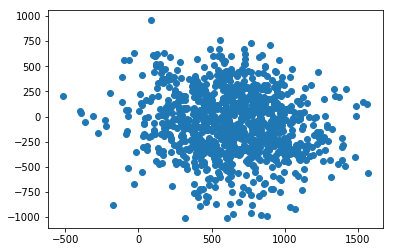

In [92]:
gen = Generator()
Gx = gen.sample(1000)
plt.scatter(Gx[:,0], Gx[:,1])

In [93]:
class MLP(object):
    def __init__(self, n_input = 2, n_hidden_1 = 300, n_hidden_2 = 300, n_classes = 2):
        # tf Graph input
        x = tf.placeholder("float", [None, n_input])
        y = tf.placeholder("float", [None, n_classes])
        self.x = x
        self.y = y
        
        # Network Parameters
        self.n_input = n_input
        self.n_hidden_1 = n_hidden_1 # 1st layer number of features
        self.n_hidden_2 = n_hidden_2 # 2nd layer number of features
        self.n_classes = n_classes
        
        # Store layers weight & bias
        weights = {
            'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
            'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
            'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
        }
        biases = {
            'b1': tf.Variable(tf.random_normal([n_hidden_1])),
            'b2': tf.Variable(tf.random_normal([n_hidden_2])),
            'out': tf.Variable(tf.random_normal([n_classes]))
        }
        self.weights = weights
        self.biases = biases
        
        # Create model
        # Hidden layer with sigmoid activation
        layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
        layer_1 = tf.nn.sigmoid(layer_1)
        # Hidden layer with sigmoid activation
        layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
        layer_2 = tf.nn.sigmoid(layer_2)
        # Output layer with linear activation
        out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
        
        self.layer_1 = layer_1
        self.layer_2 = layer_2
        self.out_layer = out_layer
        
    def train(self, X, Y, learning_rate = 0.001, training_epochs = 300, batch_size = 10, display_step = 30):
        N = len(X)
        
        # Define loss and optimizer
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.out_layer, labels=self.y))
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
        
        # Initializing the variables
        init = tf.global_variables_initializer()

        # Launch the graph
        sess = tf.Session()
        self.sess = sess
        with sess.as_default():
            sess.run(init)
            # Training cycle
            for epoch in range(training_epochs):
                avg_cost = 0.
                total_batch = int(N/batch_size)
                # Loop over all batches
                for i in range(total_batch):
                    batch_x = X[i * batch_size : (i+1) * batch_size,:]
                    batch_y = Y[i * batch_size : (i+1) * batch_size]
                    # Run optimization op (backprop) and cost op (to get loss value)
                    _, c = sess.run([optimizer, cost], feed_dict={self.x: batch_x,
                                                                  self.y: batch_y})
                    # Compute average loss
                    avg_cost += c / total_batch
                # Display logs per epoch step
                if epoch % display_step == 0:
                    print("Epoch:", '%04d' % (epoch+1), "cost=", \
                        "{:.9f}".format(avg_cost))
            print("Optimization Finished!")

    def predict(self, X):
        with self.sess.as_default():
            prediction = tf.argmax(self.out_layer, 1).eval({self.x: X})
        return(prediction)
    
    def project(self, X):
        with self.sess.as_default():
            projection = self.layer_2.eval({self.x: X})
        return(projection)

In [ ]:
class GAN(object):
    def __init__(self,
                 gen_n_input = 100, gen_n_hidden_1 = 300, gen_n_hidden_2 = 300, gen_n_out = 2,
                 crit_n_input = 2, crit_n_hidden_1 = 300, crit_n_hidden_2 = 300, crit_n_classes = 2):
       
        gen = Generator(n_input = gen_n_input, n_hidden_1 = gen_n_hidden_1, 
                        n_hidden_2 = gen_n_hidden_2, n_out = gen_n_out)
        
        crit = MLP(n_input = crit_n_input, n_hidden_1 = crit_n_hidden_1, 
                   n_hidden_2 = crit_n_hidden_2, n_classes = crit_n_classes)
        
        